In [1]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
from nltk.corpus import stopwords

In [4]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [5]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [6]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='naula i tehn.csv.bz2'

In [7]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/msie/,NaN,Мир,Обнаружена очередная дыра в MSIE 5.0,28 сентября обнаружилась очередная брешь в защ...,Наука и техника,28 обнаружиться очередной брешь защита броузер...
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/nasa/,NaN,Мир,Межпланетная станция сгорела из-за ошибки прог...,Межпланетная станция Mars Climate Orbiter стои...,Наука и техника,межпланетный станция mars climate orbiter стои...
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/netscape/,NaN,Мир,Вышел Netscape Communicator 4.7,30 сентября вышла очередная версия броузера Ne...,Наука и техника,30 очередной версия броузер netscape communica...
3,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/iceberg/,NaN,Мир,У берегов Чили появился айсберг размером с остров,"Огромный айсберг, отколовшийся от Антарктиды в...",Наука и техника,огромный айсберг отколоться антарктида 1992 пр...
4,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/interceptor/,NaN,Мир,США успешно испытали новую противоракетную сис...,В ночь с субботы на воскресенье Соединенные Шт...,Наука и техника,ночь воскресение соединить штат успешно испыта...


In [8]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [9]:
data['new_text']=data.text_lema.apply(pre_proc)

In [10]:
data.drop(data[data.text=='text'].index,inplace=True)

In [11]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/msie/,NaN,Мир,Обнаружена очередная дыра в MSIE 5.0,28 сентября обнаружилась очередная брешь в защ...,Наука и техника,28 обнаружиться очередной брешь защита броузер...,"[28, обнаружиться, очередной, брешь, защита, б..."
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/nasa/,NaN,Мир,Межпланетная станция сгорела из-за ошибки прог...,Межпланетная станция Mars Climate Orbiter стои...,Наука и техника,межпланетный станция mars climate orbiter стои...,"[межпланетный, станция, mars, climate, orbiter..."
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/netscape/,NaN,Мир,Вышел Netscape Communicator 4.7,30 сентября вышла очередная версия броузера Ne...,Наука и техника,30 очередной версия броузер netscape communica...,"[30, очередной, версия, броузер, netscape, com..."
3,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/iceberg/,NaN,Мир,У берегов Чили появился айсберг размером с остров,"Огромный айсберг, отколовшийся от Антарктиды в...",Наука и техника,огромный айсберг отколоться антарктида 1992 пр...,"[огромный, айсберг, отколоться, антарктида, 19..."
4,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/interceptor/,NaN,Мир,США успешно испытали новую противоракетную сис...,В ночь с субботы на воскресенье Соединенные Шт...,Наука и техника,ночь воскресение соединить штат успешно испыта...,"[ночь, воскресение, соединить, штат, успешно, ..."


### Модель

In [12]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 10.2 s, sys: 27.9 ms, total: 10.2 s
Wall time: 10.2 s


In [13]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 8.26 s, sys: 208 ms, total: 8.47 s
Wall time: 8.47 s


In [14]:
num_topic=10

In [15]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=num_topic, id2word = dictionary, passes=10, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -8.506972609359357
Coherence Score: 0.6612587083581978
CPU times: user 32min 22s, sys: 2.23 s, total: 32min 25s
Wall time: 26min 42s


### Топ-топики в текстах

In [16]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 6min 10s, sys: 655 ms, total: 6min 10s
Wall time: 6min 11s


In [17]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.7565,"пользователь, microsoft","[28, обнаружиться, очередной, брешь, защита, б..."
1,1,0.0,0.3541,"учёный, вода, поверхность, планета, километр, ...","[межпланетный, станция, mars, climate, orbiter..."
2,2,9.0,0.8527,"программа, версия, windows","[30, очередной, версия, броузер, netscape, com..."
3,3,0.0,0.5624,"учёный, километр, исследование","[огромный, айсберг, отколоться, антарктида, 19..."
4,4,2.0,0.3880,"ракета, вооружение, новый, система, ракетный","[ночь, воскресение, соединить, штат, успешно, ..."
5,5,9.0,0.8830,"система, windows","[1, корпорация, sun, microsystems, официально,..."
6,6,2.0,0.4577,"ракета, система","[официальный, мид, рф, владимир, рахманин, исп..."
7,7,9.0,0.4877,"система, программа, apple, версия","[5, корпорация, apple, computer, объявить, вып..."
8,8,0.0,0.5667,километр,"[тайваньский, власть, планировать, наложить, з..."
9,9,5.0,0.4807,,"[ближний, разработчик, микросхема, столкнуться..."


### Статистика по топикам

In [18]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 63.5 ms, sys: 6 µs, total: 63.5 ms
Wall time: 320 ms


### График по времени

In [19]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/naula i tehn_update.csv.bz2',compression='bz2', index=False)

CPU times: user 2min 43s, sys: 560 ms, total: 2min 44s
Wall time: 2min 45s


In [20]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

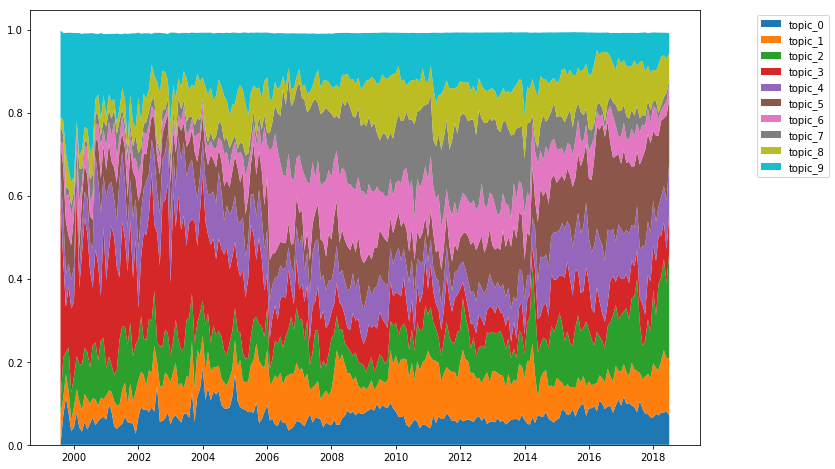

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [22]:
ldamodel1.print_topics()

[(0,
  '0.010*"учёный" + 0.007*"вода" + 0.007*"поверхность" + 0.007*"планета" + 0.006*"километр" + 0.006*"атмосфера" + 0.006*"земля" + 0.005*"исследование" + 0.005*"температура" + 0.004*"дать"'),
 (1,
  '0.018*"самолёт" + 0.014*"сша" + 0.010*"машина" + 0.009*"истребитель" + 0.009*"американский" + 0.007*"система" + 0.007*"военный" + 0.006*"полёт" + 0.006*"испытание" + 0.006*"ввс"'),
 (2,
  '0.018*"ракета" + 0.017*"россия" + 0.012*"комплекс" + 0.010*"российский" + 0.010*"проект" + 0.009*"корабль" + 0.007*"вооружение" + 0.007*"новый" + 0.006*"система" + 0.006*"ракетный"'),
 (3,
  '0.020*"космический" + 0.015*"спутник" + 0.012*"аппарат" + 0.011*"орбита" + 0.011*"станция" + 0.009*"ракета" + 0.009*"корабль" + 0.009*"запуск" + 0.007*"мкс" + 0.007*"наса"'),
 (4,
  '0.012*"учёный" + 0.008*"обнаружить" + 0.006*"найти" + 0.006*"тысяча" + 0.005*"возраст" + 0.005*"женщина" + 0.005*"вид" + 0.004*"исследование" + 0.004*"мужчина" + 0.004*"назад"'),
 (5,
  '0.017*"учёный" + 0.008*"исследование" + 0.008

### Топ слова.

In [23]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [24]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [25]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

учёный - 41198 times.
игра - 36321 times.
новый - 30892 times.
система - 28869 times.
проект - 21764 times.
сша - 19094 times.
тысяча - 17175 times.
космический - 16849 times.
ракета - 16627 times.
миллион - 16327 times.
исследование - 16216 times.
аппарат - 16074 times.
доллар - 15318 times.
3 - 14740 times.
самолёт - 14571 times.
устройство - 14301 times.
корабль - 14078 times.
дать - 14028 times.
россия - 13975 times.
новое - 13932 times.
американский - 13716 times.
часть - 13640 times.
около - 13380 times.
большой - 13118 times.
использовать - 12851 times.
версия - 12822 times.
обнаружить - 12810 times.
исследователь - 12787 times.
разработка - 12774 times.
сайт - 12748 times.
российский - 12404 times.
километр - 12185 times.
программа - 12156 times.
продажа - 11863 times.
земля - 11829 times.
2 - 11325 times.
появиться - 11317 times.
составлять - 11254 times.
пока - 10936 times.
the - 10916 times.
помощь - 10782 times.
спутник - 10485 times.
полёт - 10145 times.
последний - 10142 